# 机器学习纳米学位毕业项目--猫狗大战

实验环境：
```
-- python 3.5.4
-- cuda 8.0
-- tensorflow-gpu (1.4.0)
-- Keras (2.0.9)
-- ubuntu
-- gpu gtx 1080ti
```


## 步骤一：导入相关包

In [2]:
import seaborn as sns
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50  
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
import random
import cv2

%matplotlib inline

## 步骤二：数据预处理

从 https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/ 下载训练数据到`image目录`

数据集中 `image/train/`里的猫狗没有分类，放在一个文件夹，因为需要使用keras，需要将训练照片按照类别文件夹分类，其中猫放在一个文件夹，狗放在一个文件夹。

把数据按照4:1拆分成训练集和验证集合

img_train 里面包含两个文件夹，一个是cat，一个是dog


``` python 
├── image
│   ├── img_test 
│   │   └── test  [12500zhang]
│   ├── img_train [合计20000张]
│   │   ├── cat
│   │   └── dog
│   ├── img_valid [合计5000张]
│   │   ├── cat
│   │   └── dog

```    

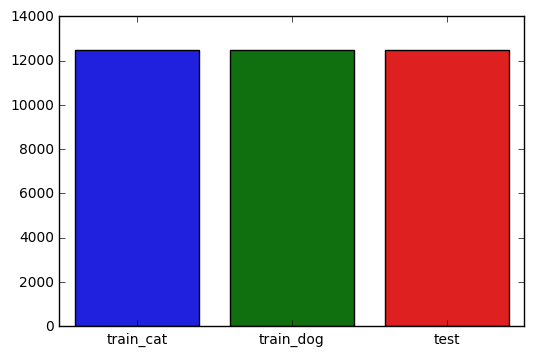

In [3]:
train_files = os.listdir('image/train')
train_cat = [x for x in train_files if 'cat' in x]
train_dog = [x for x in train_files if 'dog' in x]

x = ['train_cat', 'train_dog', 'test']
y = [len(train_cat), len(train_dog), len(os.listdir('image/test'))]
ax = sns.barplot(x=x, y=y)

In [4]:
s_count = """数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(train_cat),len(train_dog),len(os.listdir('image/test')))
s_count

'数据集中，猫的数量：12500，狗的数量：12500，测试集图片数量：12500'

## 训练集和验证集合拆分 4:1

In [5]:
from sklearn.model_selection import train_test_split
# random_state保证每次分割都一样
img_train, img_valid = train_test_split(train_files, test_size=0.2,random_state = 0)
print(len(img_train), len(img_valid))

20000 5000


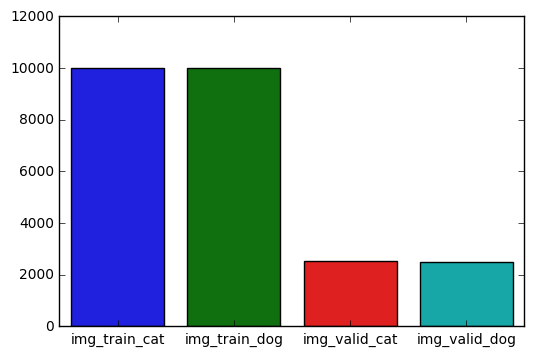

In [6]:
img_train_cat = [x for x in img_train if 'cat' in x]
img_train_dog = [x for x in img_train if 'dog' in x]
img_valid_cat = [x for x in img_valid if 'cat' in x]
img_valid_dog = [x for x in img_valid if 'dog' in x]
x = ['img_train_cat', 'img_train_dog', 'img_valid_cat', 'img_valid_dog']
y = [len(img_train_cat), len(img_train_dog), len(img_valid_cat), len(img_valid_dog)]

ax = sns.barplot(x=x, y=y)

In [7]:
print(len(img_train_cat), len(img_train_dog), len(img_valid_cat), len(img_valid_dog))

9990 10010 2510 2490


### 为了不浪费磁盘空间，我们使用`symlink`文件描述符号的方式创建文件夹

In [8]:
os.chdir("{}/image".format(os.getcwd())) 
img_test_files = os.listdir('test')

def remove_and_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    if dirname == 'img_test':
        os.mkdir(dirname+'/test')
    else:
        os.mkdir(dirname+'/cat')
        os.mkdir(dirname+'/dog')

remove_and_mkdir('img_train')
remove_and_mkdir('img_valid')
remove_and_mkdir('img_test')

for filename in img_train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in img_train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)
    
for filename in img_valid_cat:
    os.symlink('../../train/'+filename, 'img_valid/cat/'+filename)

for filename in img_valid_dog:
    os.symlink('../../train/'+filename, 'img_valid/dog/'+filename)   
    
for filename in img_test_files:
    os.symlink('../../test/'+filename, 'img_test/test/'+filename)  
    
os.chdir("..")

## 使用ImageDataGenerator进行图片预处理

- 像素值放缩到0和1之间
- 将照片进行 resized 到 224*224 供ResNet50使用

In [9]:
from keras.preprocessing.image import ImageDataGenerator

target_image_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'image/img_train',
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        'image/img_valid', 
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


#### 打印出一个batch里的照片

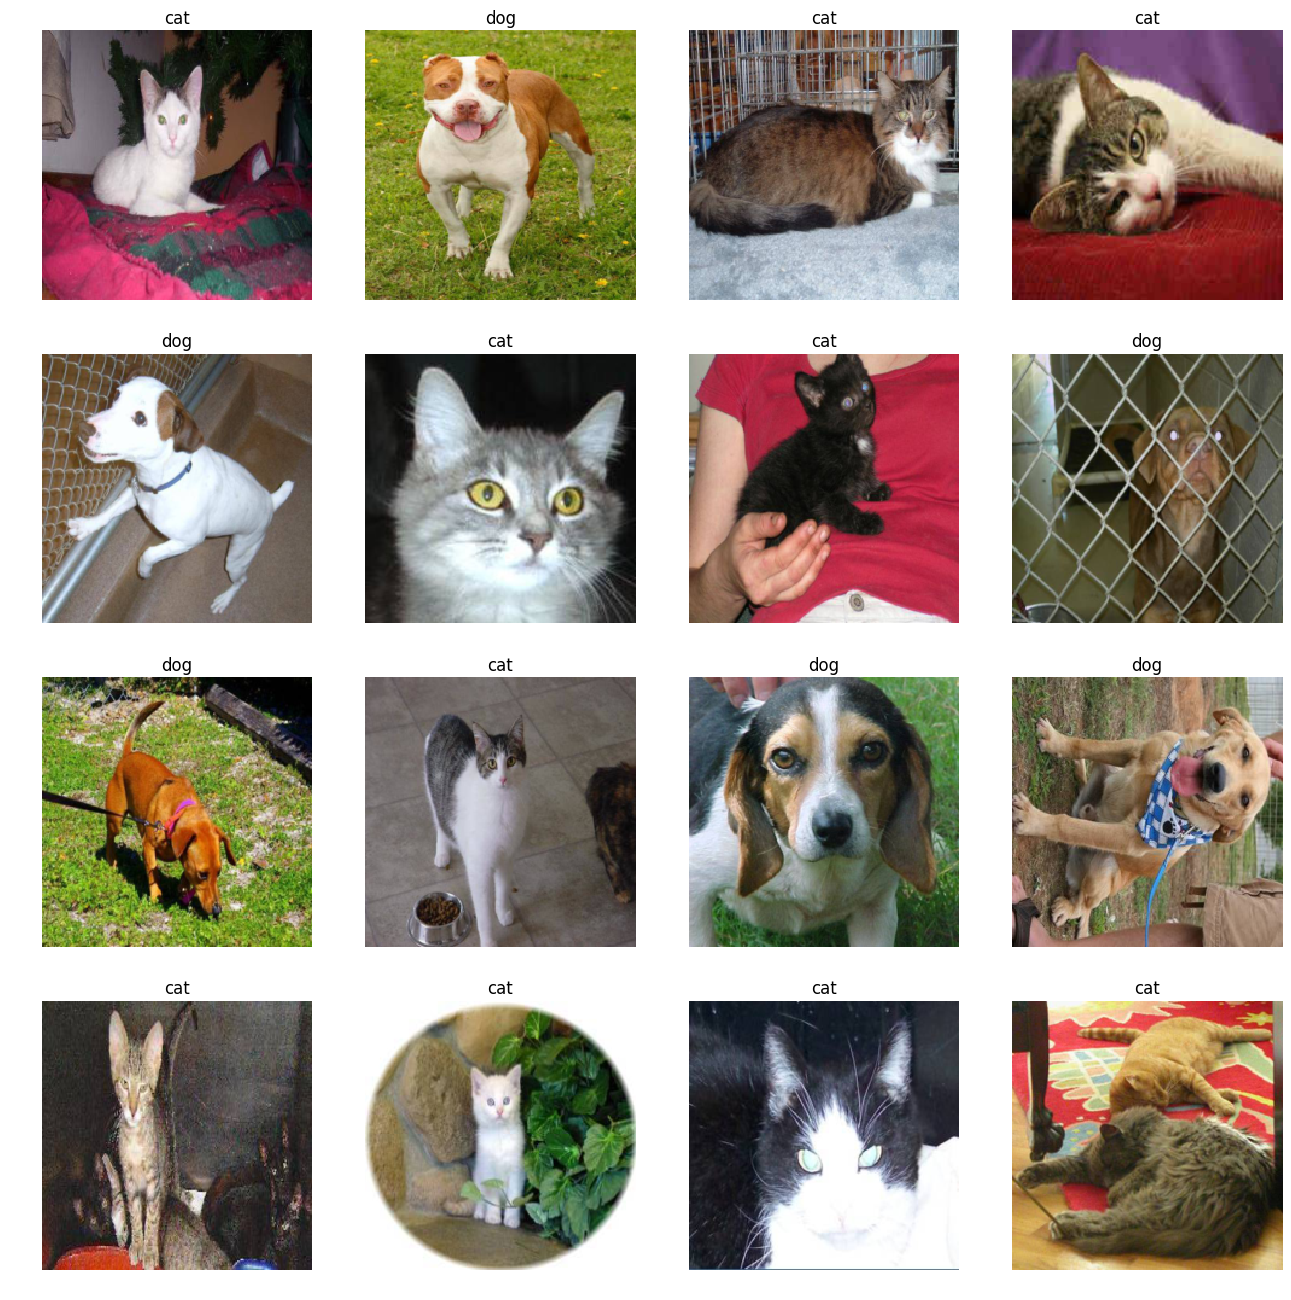

In [10]:
x, y = train_generator.next()
plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 4, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

## 步骤三：构建模型

In [11]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

### 冻结除了全连接成的所有层，获得 bottleneck 特征 

In [12]:
for layers in base_model.layers:
    layers.trainable = False

In [13]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [14]:
def train_func(loss_name,optimizer_name,model):
    model.compile(loss=loss_name, optimizer=optimizer_name, metrics=['accuracy'])
    best_model = ModelCheckpoint("resnet_best_{}_{}.h5".format(loss_name,optimizer_name), monitor='val_acc', verbose=0, save_best_only=True)
    tensor_log = "./resnet_best_{}_{}_tensor_log".format(loss_name,optimizer_name)
    return model,best_model,tensor_log

In [15]:
model,best_model,tensor_log = train_func("binary_crossentropy","adadelta",model)

### 训练并且保存最有模型

此处仅做调试使用,具体训练在train_model.py里

In [16]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2048,
        nb_epoch=10,
        validation_data=validation_generator,
        nb_val_samples=1024,
        callbacks=[best_model, TensorBoard(log_dir=tensor_log)])

/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_steps=1024, validation_data=<keras.pre..., epochs=10, callbacks=[<keras.ca..., steps_per_epoch=128)`


Epoch 1/10
128/128 [==============================] - 66s 517ms/step - loss: 0.5032 - acc: 0.7642 - val_loss: 0.7502 - val_acc: 0.5040
Epoch 2/10
128/128 [==============================] - 63s 491ms/step - loss: 0.2738 - acc: 0.8848 - val_loss: 0.7076 - val_acc: 0.4828
Epoch 3/10
128/128 [==============================] - 63s 493ms/step - loss: 0.2187 - acc: 0.9170 - val_loss: 0.7684 - val_acc: 0.4877
Epoch 4/10
128/128 [==============================] - 64s 500ms/step - loss: 0.1795 - acc: 0.9360 - val_loss: 0.8475 - val_acc: 0.5108
Epoch 5/10
128/128 [==============================] - 64s 498ms/step - loss: 0.1603 - acc: 0.9385 - val_loss: 0.6507 - val_acc: 0.6370
Epoch 6/10
128/128 [==============================] - 64s 499ms/step - loss: 0.1610 - acc: 0.9438 - val_loss: 0.4522 - val_acc: 0.7779
Epoch 7/10
128/128 [==============================] - 64s 502ms/step - loss: 0.1447 - acc: 0.9395 - val_loss: 0.2031 - val_acc: 0.9127
Epoch 8/10
128/128 [==============================] - 6

# 步骤四: 导入训练好的权重预测数据

```
samples_per_epoch=2048,
nb_epoch=40,
nb_val_samples=1024,
```        

### 读取照片，并进行预处理

In [15]:
def get_image(image_num):
    img = cv2.imread('image/test/{}.jpg'.format(image_num))
    img = cv2.resize(img, target_image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img
test_num = 12500

### 生成kaggle提交文件

In [23]:
# 生成文件
def generate_kaggle_file(pred_array,file_name):
    df = pd.read_csv("sample_submission.csv")
    df["label"] = pred_array
    print(file_name)
    df.to_csv('submission_{}.csv'.format(file_name), index=None)

In [17]:
from tqdm import *

image_matrix = np.zeros((test_num,target_image_size[0], target_image_size[0], 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

100%|██████████| 12500/12500 [00:21<00:00, 559.96it/s]


In [24]:
opt_list = ["adadelta","adam","sgd"]
for opt in opt_list:
    weights_name = 'resnet_best_binary_crossentropy_{}.h5'.format(opt)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred,opt)

12500/12500 [==============================] - 41s 3ms/step
file_name
12500/12500 [==============================] - 41s 3ms/step
file_name
12500/12500 [==============================] - 41s 3ms/step
file_name


## 预测结果分数

| 优化器 | 分数 |
| --- | --- |
|adadelta| 0.06771 |
|adam| 0.06592 |
|sgd| 0.06603 |

### 对照片进行随机预测

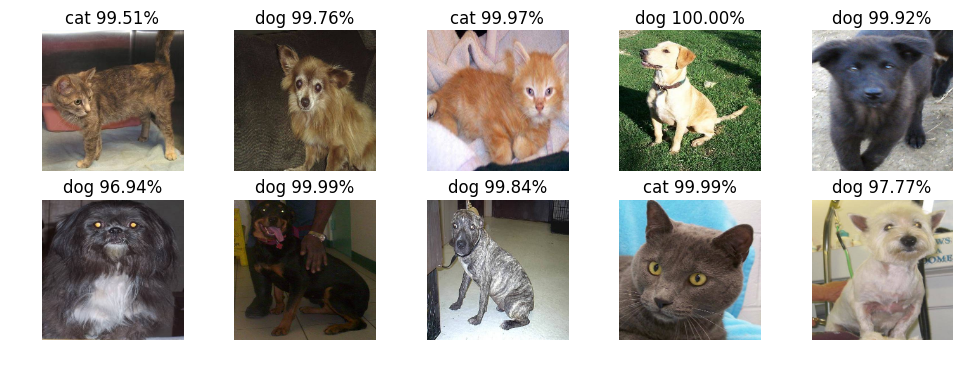

In [26]:
plt.figure(figsize=(12, 4))
for i in range(10):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    
    plt.subplot(2, 5, i+1)
    
    if prediction < 0.5:
        
        plt.title("cat {:.2f}%".format(100 - float(prediction)*100))
    else:
        plt.title("dog {:.2f}%".format(float(prediction)*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) 